In [1]:
from functools import partial

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp

In [3]:
features = pd.read_csv('features.csv', index_col=0, parse_dates=True)
features.shape

(5808, 10)

In [4]:
targets = pd.read_csv('targets.csv', index_col=0, parse_dates=True)
features.shape

(5808, 10)

## Предварительный анализ

In [5]:
# типы данных признаков
features.dtypes

A_rate      float64
A_CH4       float64
A_C2H6      float64
A_C3H8      float64
A_iC4H10    float64
A_nC4H10    float64
A_iC5H12    float64
A_nC5H12    float64
A_C6H14     float64
B_rate      float64
dtype: object

In [6]:
# типы данных целевых переменных
targets.dtypes

B_C2H6      float64
B_C3H8      float64
B_iC4H10    float64
B_nC4H10    float64
dtype: object

In [7]:
# Индексы совпадают
(features.index == targets.index).all()

True

In [8]:
features.index.to_series().diff().value_counts()

0 days 00:30:00    5807
Name: timestamp, dtype: int64

In [9]:
targets.index.to_series().diff().value_counts()

0 days 00:30:00    5807
Name: timestamp, dtype: int64

Приведение к постоянной частоте дискретизации временного ряда не требуется

In [10]:
features.describe()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
count,5807.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,5675.000000
mean,59.346948,0.159890,4.290739,37.990406,17.343168,24.413897,4.948636,4.809805,5.995740,64.817202
std,20.684895,0.068488,0.912565,3.756424,0.754301,1.274795,1.230539,1.285549,1.543956,10.696414
min,0.000321,0.008045,0.280524,11.345740,11.143152,18.655932,3.033678,1.338103,2.924722,0.000000
25%,61.846908,0.109331,3.971011,37.647968,17.018272,23.746663,4.462670,4.353103,5.574106,63.852030
50%,67.010148,0.139924,4.485758,38.618187,17.327200,24.138643,4.684908,4.619459,5.708216,68.583359
75%,69.734038,0.212163,4.844390,39.402360,17.685803,24.615843,5.086816,4.925770,6.032535,71.171153
max,74.560399,0.471429,6.418897,42.860283,20.353500,35.498867,13.812560,14.845480,30.656385,89.958390


In [11]:
targets.describe()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
count,5624.000000,5628.000000,5628.000000,5628.000000
mean,4.363701,37.742757,16.843028,24.171264
std,2.931240,2.218569,1.059827,1.480740
min,0.861025,0.026142,0.012764,0.019941
25%,3.503610,36.827096,16.548084,23.736470
50%,4.395271,37.750088,16.934576,24.147675
75%,4.680156,38.730979,17.292647,24.642044
max,91.573613,61.931856,19.235807,27.184879


<AxesSubplot:xlabel='timestamp'>

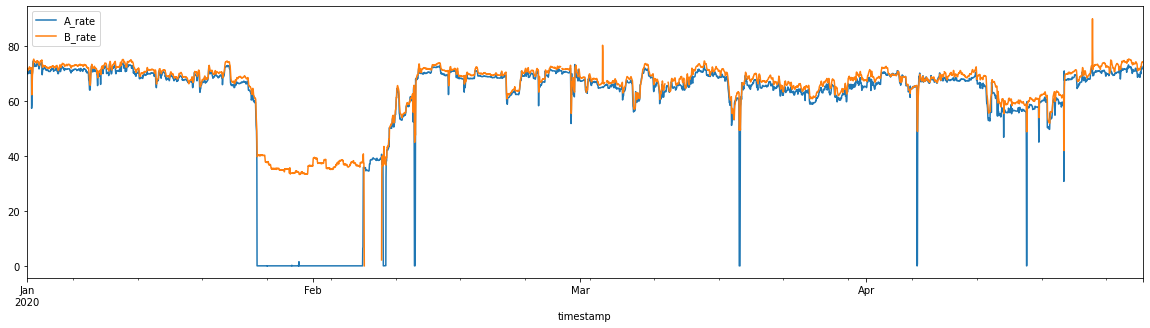

In [12]:
# Объемный расход
rate_mask = features.columns.str.contains('rate')

features.loc[:, rate_mask].plot(figsize=(20, 5))

<AxesSubplot:xlabel='timestamp'>

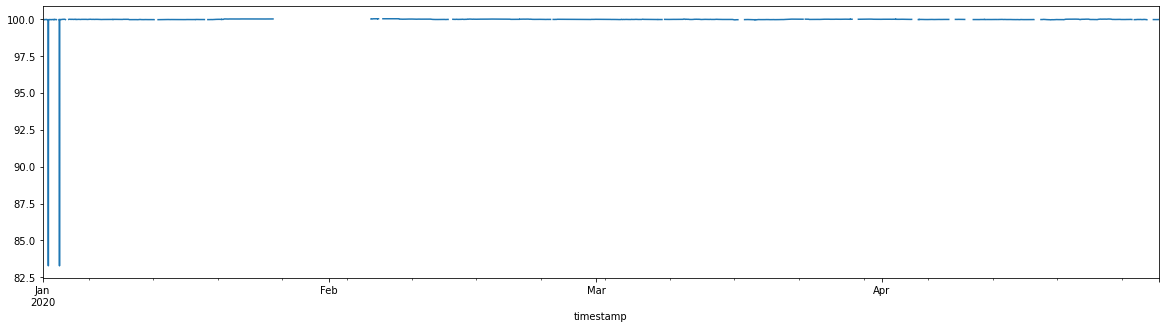

In [13]:
features.loc[:, ~rate_mask].sum(axis=1, skipna=False)\
.plot(figsize=(20, 5))

Содержание компонентов приведено в процентных долях.

## Обработка данных

### Исключение выбросов по расходу

<AxesSubplot:xlabel='timestamp'>

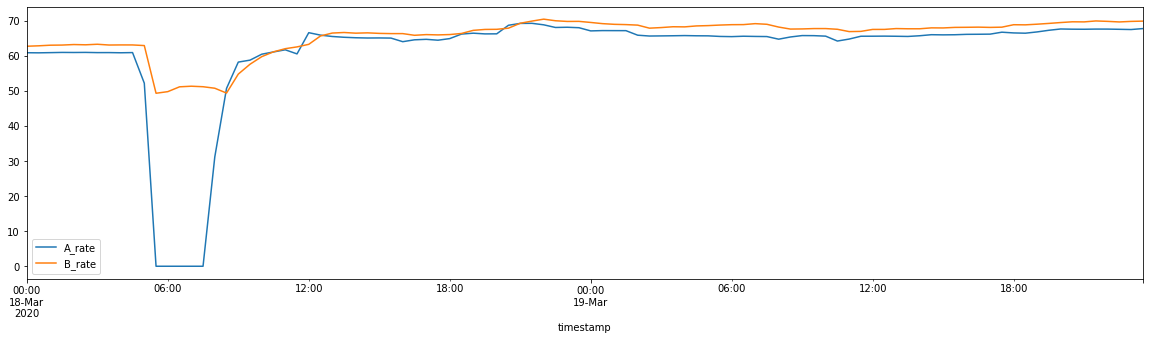

In [14]:
# визуальная оценка продолжительности пиковых выбросов для подбора
# подходящего алгоритма
features.loc['2020-03-18' : '2020-03-19', rate_mask].plot(figsize=(20, 5))

<AxesSubplot:>

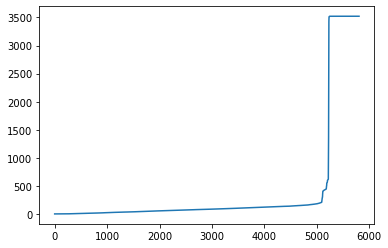

In [15]:
# исключение выбросов по разности текущего значения временного ряда
# со средним (squared difference, sd)
sd = (features['A_rate'] - features['A_rate'].mean()) ** 2
# сортировка для поиска критического значения
sd_sorted = pd.Series(np.sort(sd.values))
sd_sorted.plot()

<AxesSubplot:>

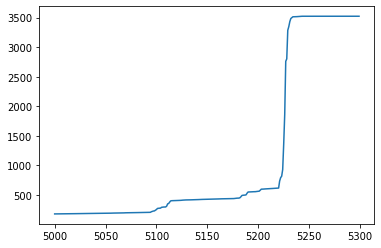

In [16]:
sd_sorted[5000:5300].plot()

In [17]:
# визуально определяется критическое значение квадрата разности 
# текущего значения и среднего -
# точка, в которой начинается резкий рост данной величины
crit_sd = sd_sorted[5100]
# маска выбросов
outlier_mask = sd > crit_sd

In [18]:
# исключение выбросов с нулевым расходом B
outlier_mask |= features['B_rate'] == 0

In [19]:
# объединение фреймов для дальнейшей обработки
raw = pd.concat([features, targets], axis=1)
rate_cols = features.columns[rate_mask]

<AxesSubplot:xlabel='timestamp'>

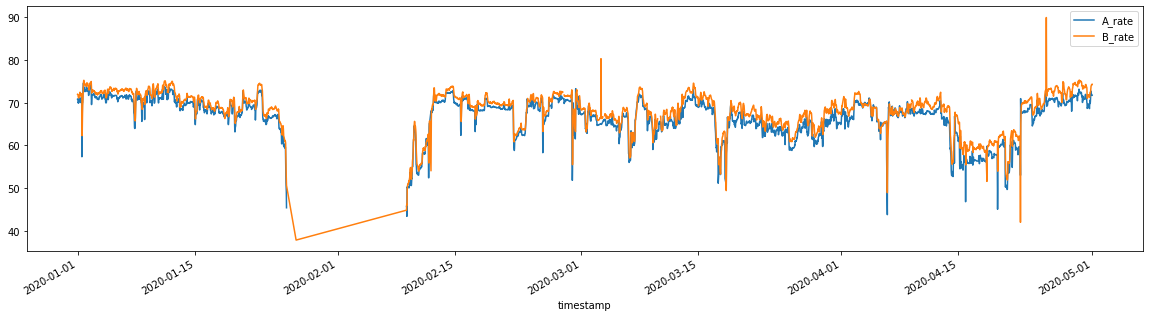

In [20]:
raw.loc[~outlier_mask, rate_cols].plot(figsize=(20, 5))

In [21]:
raw[outlier_mask] = np.nan

### Оценка технологических выбросов

In [22]:
# Расход газовой смеси с неизвестным содержанием компонентов
imp_flow = raw['B_rate'] - raw['A_rate']
imp_flow.describe()

count    5057.000000
mean        1.582401
std         1.319358
min       -14.483657
25%         0.966452
50%         1.489447
75%         2.223649
max        19.034531
dtype: float64

<AxesSubplot:xlabel='timestamp'>

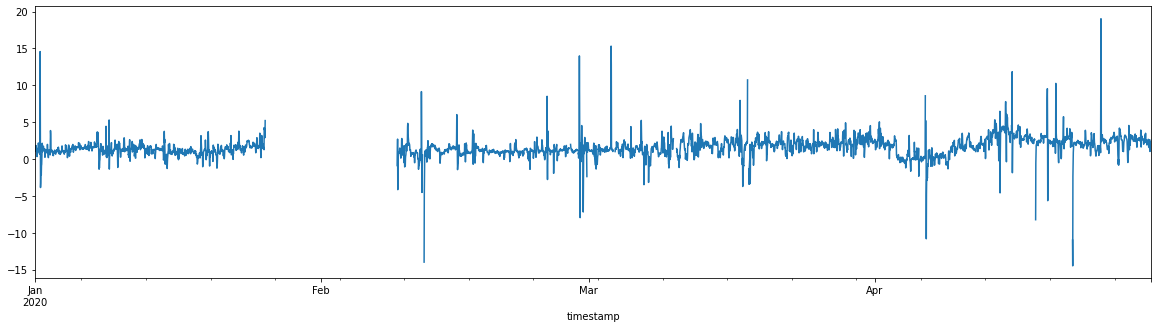

In [23]:
imp_flow.plot(figsize=(20, 5))

In [24]:
# Доля отрицательных значений
(imp_flow < 0).mean()

0.05130853994490358

__Возможные причины отрицательных значений объемного расхода примесей:__  
Сжимаемость газа - ведет к лагу между объемным расходом в A и B  
Различное давление, температура и состав газовой смеси в рассматриваемых точках трубопровода  
Отбор газа между точками A, B  
Погрешность средств измерения

### Лаг расходов в точках A, B 

In [25]:
def shift_apply(left, right, func, shift_range, **kwargs):
    '''
    Apply function on shifted left and right series
    for each shift in range.
    
    Parameters
    ----------
    left, right : pd.Series
    
    func : callable
    func(shifted_left, right)
    
    shift_range : list
    Shift values for left series.
    Positive shift value applied to index means previous left values
    corresponds with current right values.
    
    **kwargs : func kwargs
    
    Returns
    -------
    dict
    {shift : func_value}
    '''
    return {sh : func(left.shift(sh), right, **kwargs)
            for sh in shift_range}

In [26]:
def mutual_nan(*arr):
    '''
    Return boolean mask for any nan values with same index in arrays.
    
    Parameters
    ----------
    arr : 1d np.ndarray
    
    Return
    ------
    np.ndarray, dtype=bool
    '''
    na_mask = np.array([np.isnan(a) for a in arr]).T
    na_mask = na_mask.any(axis=1)
    return na_mask

In [27]:
def mi(x, y, normed=False, **kwargs):
    '''
    Mutual information for continious variables.
    Ignores nan values.
    
    Parameters
    ----------
    x, y : 1d np.ndarray
    
    normed : bool
    Divide mutual information on maximum mutual information.
    
    Return
    ------
    float
    '''
    na_mask = mutual_nan(x, y)
    x_notna, y_notna = (np.array(a[~na_mask]) for a in (x, y))
    mi = mutual_info_regression(x_notna[:, np.newaxis], y_notna)
    if normed:
        max_mi = mutual_info_regression(y_notna[:, np.newaxis], y_notna)
        return (mi / max_mi)[0]
    else:
        return mi[0]

<AxesSubplot:>

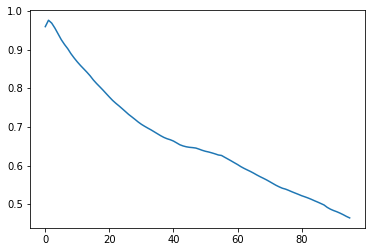

In [28]:
# По расходу
rate_corr = pd.Series(shift_apply(raw['A_rate'],
                                  raw['B_rate'],
                                  pd.Series.corr,
                                  range(0, 96)))
rate_corr.plot()

In [29]:
# Лаг с максимальным значением корреляции между временными рядами
rate_corr.idxmax()

1

<AxesSubplot:>

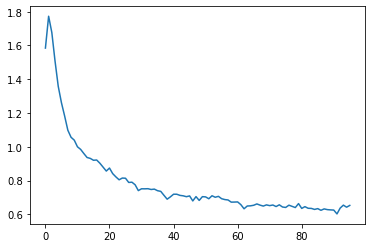

In [30]:
# По расходу
rate_mi = pd.Series(shift_apply(raw['A_rate'],
                                  raw['B_rate'],
                                  mi,
                                  range(0, 96)))
rate_mi.plot()

In [31]:
# Лаг с максимальным значением взаимной информации между временными рядами
rate_mi.idxmax()

1

In [32]:
# Расход газовой смеси с неизвестным содержанием компонентов c учетом лага
imp_flow = raw['B_rate'] - raw['A_rate'].shift(1)
imp_flow.describe()

count    5050.000000
mean        1.593549
std         1.018133
min        -5.814973
25%         1.020342
50%         1.471497
75%         2.192691
max        17.891448
dtype: float64

In [33]:
# Доля положительных значений
(imp_flow < 0).mean()

0.03340220385674931

## Feature engineering

In [34]:
# Названия компонент
comp_cols = targets.columns.str[2:]

### Определение временного лага для содержания компоненты

<AxesSubplot:>

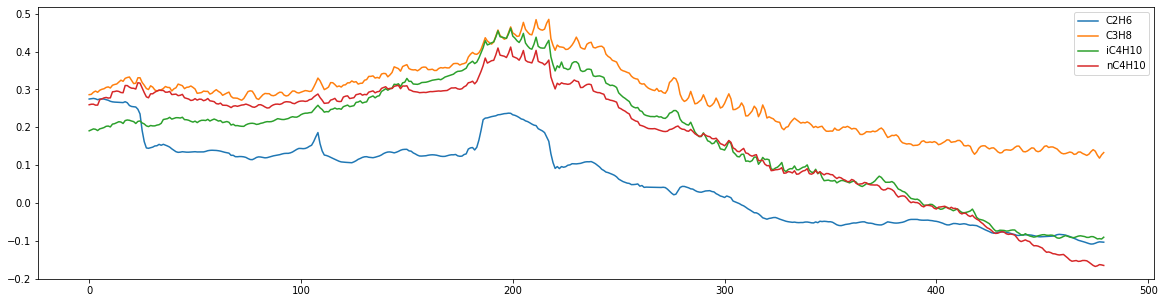

In [35]:
# По коэффициенту корреляции содержания компонентов в A и B
comp_corr = pd.DataFrame()
for c in comp_cols:
    comp_corr[c] = pd.Series(shift_apply(raw[f'A_{c}'],
                                         raw[f'B_{c}'],
                                         pd.Series.corr,
                                         range(0, 480)))
comp_corr.plot(figsize=(20, 5))

<AxesSubplot:>

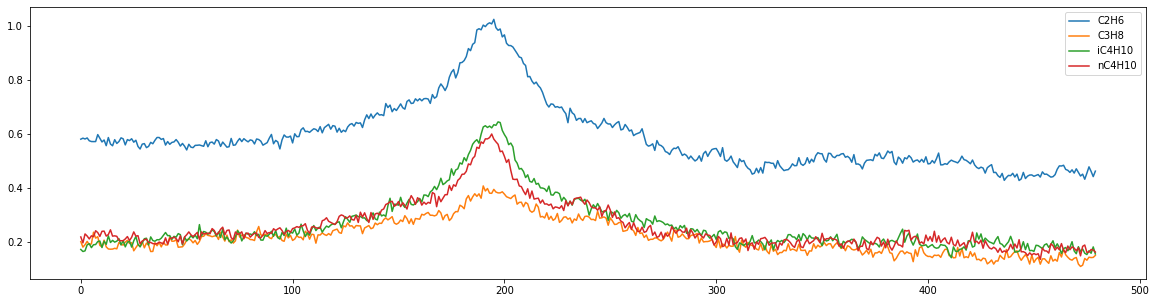

In [36]:
# По взаимной информации содержания компонентов в A и B
comp_mi = pd.DataFrame()
for c in comp_cols:
    comp_mi[c] = pd.Series(shift_apply(raw[f'A_{c}'],
                                       raw[f'B_{c}'],
                                       mi,
                                       range(0, 480)))
comp_mi.plot(figsize=(20, 5))

In [37]:
shift_init_report = pd.concat([comp_corr.abs().idxmax(),
                               comp_mi.abs().idxmax()],
                              axis=1,
                              keys=['corr', 'mi'])
shift_init_report

,corr,mi
C2H6,2,195
C3H8,217,190
iC4H10,199,197
nC4H10,199,194


In [38]:
# Добавление смещенных по времени временных рядов исходных признаков
for c in comp_cols:
    opt_shift = shift_init_report.loc[c, 'mi']
    raw[f'A_{c}_sh'] = raw[f'A_{c}'].shift(opt_shift)

### Расчетный объем компонент

__Закон сохранения массы для участка A, B:__
$$F_{iB} = F_{iA} + F_{iU}\ (1)$$
$F_{iB}$ - массовый расход i-го компонента в точке B  
$F_{iA}$ - массовый расход i-го компонента в точке A  
$F_{iU}$ - массовый расход i-го компонента в потоках с неизвестным содержанием,  
добавляемым между A и B  
__Cодержание компонента в долях от расхода:__
$$c_{i} = \frac{F_i}{F}\ (2)$$
$c_{i}$ - содержание компонента в долях  
$F_i$ - массовый расход компонента  
$F$ - массовый расход смеси  
__Cодержание компонента в долях в точке B:__  
из (1), (2):
$$c_{iB} = \frac{c_{iA}F_A + c_{iU}(F_B - F_A)}{F_B}\ (3)$$
$F_A$ - массовый расход смеси в точке A  
$F_B$ - массовый расход смеси в точке B  
$c_{iA}$ - доля компонента в точке A  
$c_{iU}$ - доля компонента в потоках с неизвестным содержанием

In [39]:
# первое слагаемое уравнения (3)
raw['r_' + comp_cols] =\
raw['A_' + comp_cols].mul(raw['A_rate'].values /
                          raw['B_rate'].values,
                          axis=0)

<AxesSubplot:>

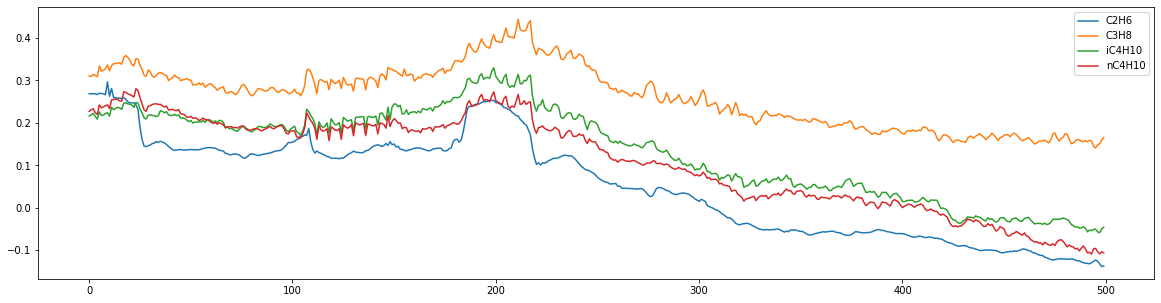

In [40]:
# корреляция для первого слагаемого
rc_c_corr = pd.DataFrame()
for c in comp_cols:
    rc_c_corr[c] = pd.Series(shift_apply(raw[f'r_{c}'],
                                           raw[f'B_{c}'],
                                           pd.Series.corr,
                                           range(0, 500))
                              )
rc_c_corr.plot(figsize=(20, 5))

<AxesSubplot:>

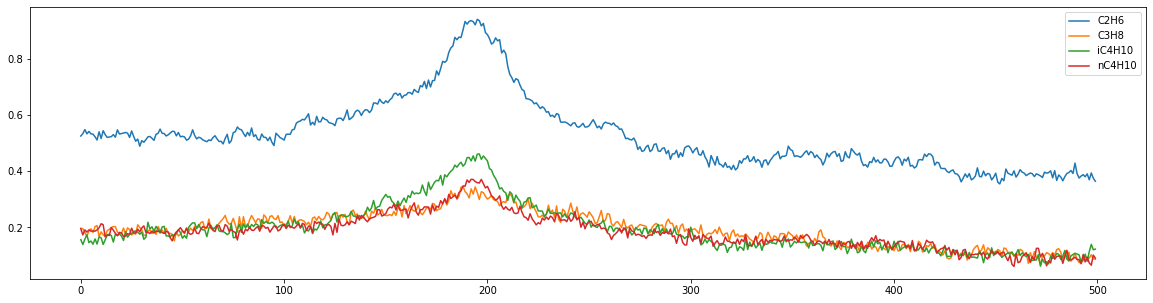

In [41]:
rc_c_mi = pd.DataFrame()
for c in comp_cols:
    rc_c_mi[c] = pd.Series(shift_apply(raw[f'r_{c}'],
                                           raw[f'B_{c}'],
                                           mi,
                                           range(0, 500))
                              )
rc_c_mi.plot(figsize=(20, 5))

In [42]:
shift_fe_report = pd.concat([rc_c_corr.abs().idxmax(),
                             rc_c_mi.abs().idxmax()],
                            axis=1,
                            keys=['corr', 'mi'])
shift_fe_report

,corr,mi
C2H6,9,195
C3H8,211,188
iC4H10,199,196
nC4H10,23,192


In [43]:
# Добавление смещенных по времени временных рядов расчетных признаков
for c in comp_cols:
    opt_shift = shift_fe_report.loc[c, 'mi']
    raw[f'r_{c}_sh'] = raw[f'r_{c}'].shift(opt_shift)

In [44]:
# второе слагаемое уравнения (3)
raw['r_rate'] = (raw['B_rate'] - raw['A_rate']) / raw['B_rate']

<AxesSubplot:>

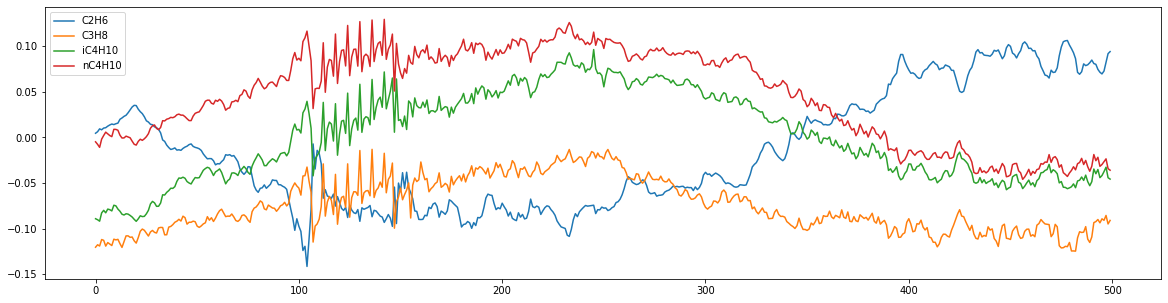

In [45]:
rrate_c_corr = pd.DataFrame()
for c in comp_cols:
    rrate_c_corr[c] = pd.Series(shift_apply(raw[f'r_rate'],
                                           raw[f'B_{c}'],
                                           pd.Series.corr,
                                           range(0, 500))
                              )
rrate_c_corr.plot(figsize=(20, 5))

<AxesSubplot:>

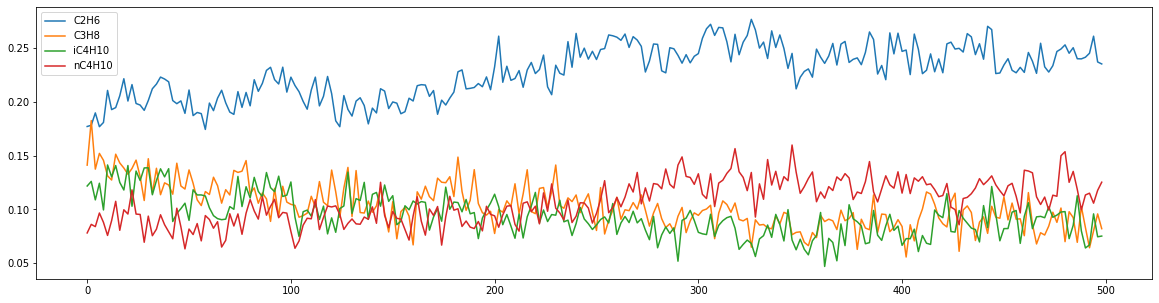

In [46]:
rrate_c_mi = pd.DataFrame()
for c in comp_cols:
    rrate_c_mi[c] = pd.Series(shift_apply(raw[f'r_rate'],
                                         raw[f'B_{c}'],
                                         mi,
                                         range(0, 500, 2))
                              )
rrate_c_mi.plot(figsize=(20, 5))

Коэффициенты корреляции второго слагаемого и целевых переменных ниже 0.2 при любом лаге, тенденции на графике взаимной информации визуально признак не заметны. Признак не рассматривается в дальнейшем.

### Cкользящее среднее

Скользящее среднее применяется для использования информации об объемном расходе и содержании компонентов в точке A за период.

#### объемный расход

Т.к. процентная доля компонентнов не обладает аддитивностью, добавляется признак объемного расхода компонентов в точке A

In [47]:
# объемный расход компонентов
raw['Ar_' + comp_cols] = raw['A_' + comp_cols].mul(raw['A_rate'],
                                                   axis=0)

<AxesSubplot:>

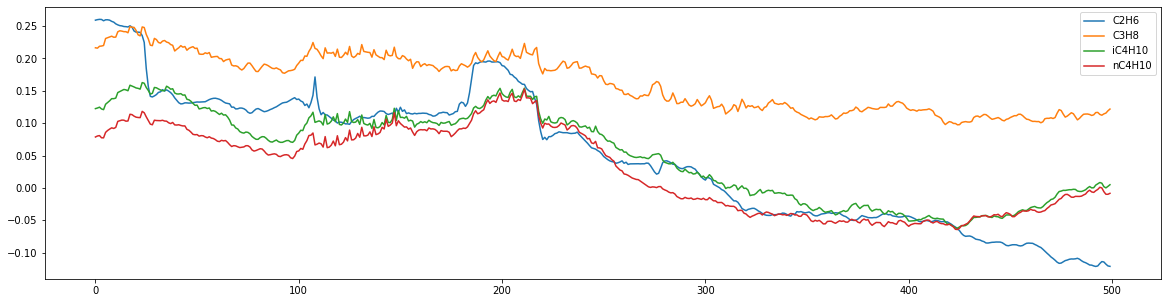

In [48]:
# коэффициенты корреляции объемного расхода компонента в точке A
# и содержания соответствующего компонента в точке B
cr_c_corr = pd.DataFrame()
for c in comp_cols:
    cr_c_corr[c] = pd.Series(shift_apply(raw[f'Ar_{c}'],
                                         raw[f'B_{c}'],
                                         pd.Series.corr,
                                         range(0, 500))
                              )
cr_c_corr.plot(figsize=(20, 5))

<AxesSubplot:>

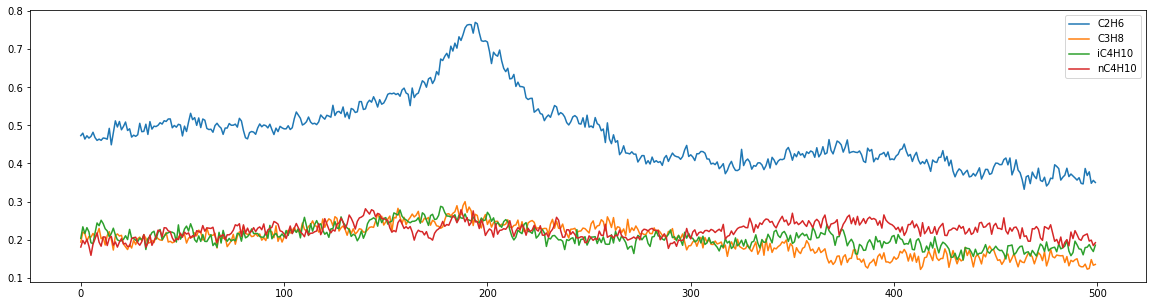

In [49]:
# взаимная информация объемного расхода компонента в точке A
# и содержания соответствующего компонента в точке B
cr_c_mi = pd.DataFrame()
for c in comp_cols:
    cr_c_mi[c] = pd.Series(shift_apply(raw[f'Ar_{c}'],
                                        raw[f'B_{c}'],
                                         mi,
                                         range(0, 500))
                              )
cr_c_mi.plot(figsize=(20, 5))

In [50]:
# Ширина окна для скользящего среднего определяется визуально 
# по графику взаимной информации объемного расхода компонента в точке A
# и содержанию соответствующего компонента в точке B

window = 60

# скользящее среднее объемного расхода компонентов
raw['Ar_' + comp_cols + '_ma'] =\
raw['Ar_' + comp_cols].rolling(window).mean()

<AxesSubplot:>

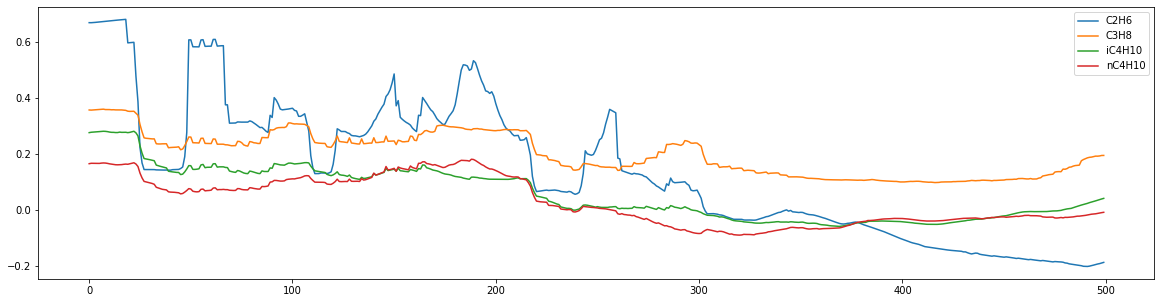

In [51]:
crma_c_corr = pd.DataFrame()
for c in comp_cols:
    crma_c_corr[c] = pd.Series(shift_apply(raw[f'Ar_{c}_ma'],
                                         raw[f'B_{c}'],
                                         pd.Series.corr,
                                         range(0, 500))
                              )
crma_c_corr.plot(figsize=(20, 5))

In [52]:
# Добавление смещенных по времени скользящего среднего объемного 
# расхода компонентов
for c in comp_cols:
    col = f'Ar_{c}_ma'
    opt_shift = crma_c_corr[c].abs().idxmax()
    raw[f'{col}_sh'] = raw[col].shift(opt_shift)

Коэффициенты корреляции объемного расхода компонента в точке A и содержания компонента в точке B ниже, чем коэффициенты корреляции содержания компонентов в А и B, поэтому далее рассматривается скользящее среднее для содержания компонентов.

#### содержание компонентов

<AxesSubplot:>

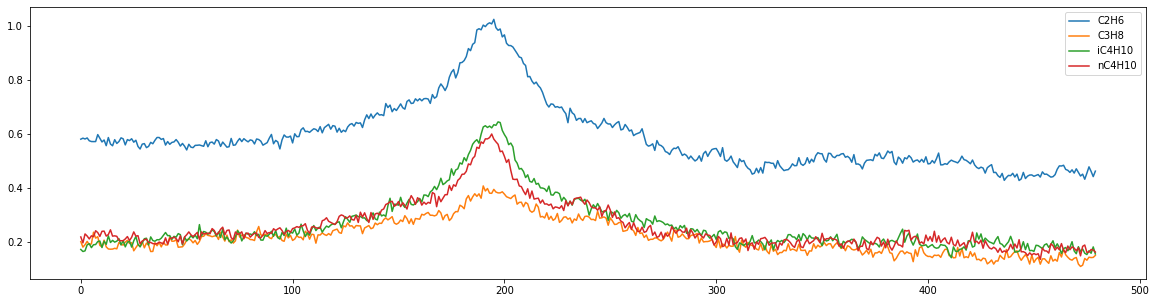

In [53]:
# Ширина окна для скользящего среднего определяется визуально 
# по графику взаимной информации содержания компонентов
comp_mi.plot(figsize=(20, 5))

In [54]:
# добавление скользящего среднего содержания компонентов в A
window = 60
raw['A_' + comp_cols + '_ma'] =\
raw['A_' + comp_cols].rolling(window).mean()

<AxesSubplot:>

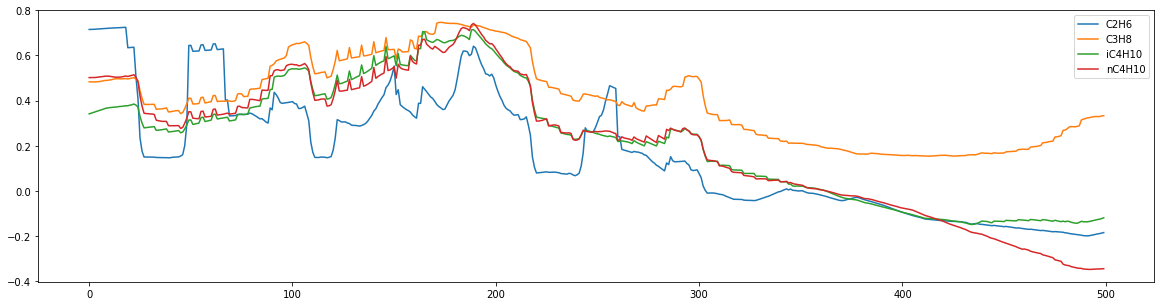

In [55]:
# коэффициенты корреляции скользящего среднего содержания компонентов в A
# и текущего содержания B
cma_c_corr = pd.DataFrame()
for c in comp_cols:
    cma_c_corr[c] = pd.Series(shift_apply(raw[f'A_{c}_ma'],
                                         raw[f'B_{c}'],
                                         pd.Series.corr,
                                         range(0, 500))
                              )
cma_c_corr.plot(figsize=(20, 5))

In [56]:
# Добавление смещенных по времени скользящего среднего 
# содержания компонентов
for c in comp_cols:
    col = f'A_{c}_ma'
    opt_shift = cma_c_corr[c].abs().idxmax()
    raw[f'{col}_sh'] = raw[col].shift(opt_shift)

__Гауссовское скользящее среднее__

In [57]:
# добавление скользящего среднего с гауссовским окном
# содержания компонентов в A
raw['A_' + comp_cols + '_gma'] =\
raw['A_' + comp_cols].rolling(window, win_type='gaussian').mean(std=10)

<AxesSubplot:>

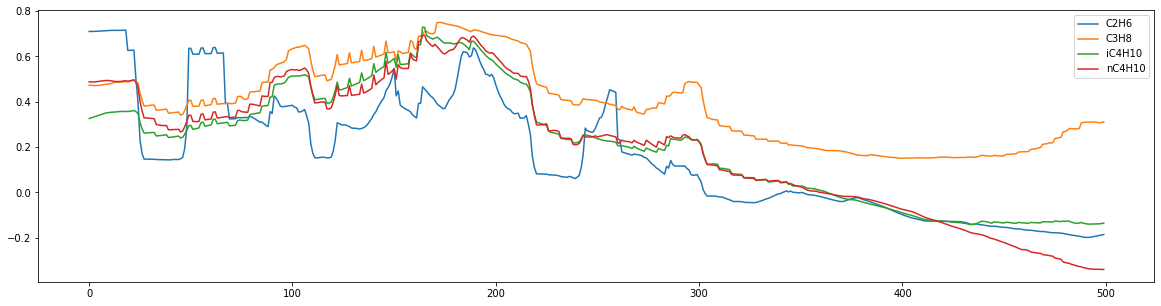

In [58]:
# коэффициенты корреляции скользящего среднего c гауссовским окном
# содержания компонентов в A и содержания компонентов в A

cgma_c_corr = pd.DataFrame()
for c in comp_cols:
    cgma_c_corr[c] = pd.Series(shift_apply(raw[f'A_{c}_gma'],
                                         raw[f'B_{c}'],
                                         pd.Series.corr,
                                         range(0, 500))
                              )
cgma_c_corr.plot(figsize=(20, 5))

In [59]:
# Добавление смещенных по времени скользящего среднего 
# с гауссовским окном содержания компонентов
for c in comp_cols:
    col = f'A_{c}_gma'
    opt_shift = cma_c_corr[c].abs().idxmax()
    raw[f'{col}_sh'] = raw[col].shift(opt_shift)

### Сравнение корреляций обработанных временных рядов

In [60]:
# Максимальные значения коэффициентов корреляции по модулю 
# при различных способах обработки данных
pd.concat([corr.abs().max() for corr in [comp_corr,
                                         rc_c_corr,
                                         crma_c_corr,
                                         cma_c_corr,
                                         cgma_c_corr]
          ],
          axis=1,
          keys=['A_comp',
                'A_comp_ratio',
                'A_comp_rate_ma',
                'A_comp_ma',
                'A_comp_gaussian_ma'])

,A_comp,A_comp_ratio,A_comp_rate_ma,A_comp_ma,A_comp_gaussian_ma
C2H6,0.276267,0.296663,0.681756,0.724343,0.715465
C3H8,0.485261,0.444017,0.360857,0.746347,0.749773
iC4H10,0.462038,0.330008,0.281881,0.714269,0.728739
nC4H10,0.412030,0.280482,0.181982,0.741413,0.692962


## Выбор метрики

В качестве метрики используются RMSE - корень из среднеквадратической ошибки. Метрика имеет ту же размерность, что и прогнозируемая величина, что позволяет сопоставить ошибку модели с погрешностью СИ и среднеквадратическим отклонением временного ряда.

## Прогнозирование

In [61]:
report = pd.DataFrame()

### Линейная модель на исходных признаках со смещением (baseline)

Для прогнозирования содержания компоненты в точке B будет использован только один признак - содержание соответствующей компоненты в точке A, т.к. содержания других компонентов мультиколлинеарны
$$\sum_{i=1}^{n}c_i = 100$$
$c_i$ - содержание i-ой компоненты, %  
$n$ - количество компонентов

Использование расхода B как признака нецелесообразно, т.к. на момент прогнозирования он неизвестен.

In [62]:
for c in comp_cols:
    # выбор признаков и целевой переменной
    X_cols = [f'A_{c}_sh']
    y_col = f'B_{c}'
    mask = raw.notna()[X_cols + [y_col]].all(axis=1)
    # разбиение на отложенную выборку
    n = int(mask.sum() * 0.8)
    train = raw[mask].iloc[:n]
    test = raw[mask].iloc[n:]
    
    # обучение
    lr = LinearRegression()
    lr.fit(train[X_cols],
           train[y_col])
    
    # оценка на отложенной выборке
    y_pred = lr.predict(test[X_cols])
    report.loc['lin_init', c] = mean_squared_error(test[y_col],
                                                   y_pred,
                                                   squared=False)

In [63]:
report

,C2H6,C3H8,iC4H10,nC4H10
lin_init,3.762738,1.443716,0.979999,1.502085


### Линейная модель на исходных признаках со смещением и подбором гиперпараметров

In [64]:
def cv_score(kwargs, X, y):
    est = Pipeline([('scaler', StandardScaler()),
                    ('estimator', ElasticNet(**kwargs))
                   ])
    scores = cross_val_score(est,
                             X,
                             y,
                             cv=5,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1)
    return -scores.mean()

In [65]:
exp_lim = np.array([-3, 1]) / np.log10(np.e) # from 1e-3 to 1e1
space = {'alpha': hp.loguniform('alpha', *exp_lim),
         'l1_ratio' : hp.uniform('l1_ratio', 0, 1),
        }

In [66]:
def eval_model(raw,
               X_cols,
               y_col,
               space,
               test_ratio=0.8,
               max_cv_iter=100):
    # маска notna значений
    mask = raw.notna()[X_cols + [y_col]].all(axis=1)
    # разбиение на отложенную выборку
    n = int(mask.sum() * test_ratio)
    train = raw[mask].iloc[:n]
    test = raw[mask].iloc[n:]
        
    # подбор гиперпараметров
    res = fmin(partial(cv_score,
                       X=train[X_cols],
                       y=train[y_col]),
               space,
               tpe.suggest,
               max_evals=max_cv_iter)
        
    # обучение
    lr = Pipeline([('scaler', StandardScaler()),
                   ('estimator', ElasticNet(**res))
                   ])
    lr.fit(train[X_cols],
           train[y_col])
        
    # оценка на отложенной выборке
    y_pred = lr.predict(test[X_cols])
    return mean_squared_error(test[y_col],
                              y_pred,
                              squared=False)

In [67]:
for c in comp_cols:
    print(c)
    X_cols = [f'A_{c}_sh']
    y_col = f'B_{c}'
    report.loc['lin_init_cv', c] = eval_model(raw,
                                              X_cols,
                                              y_col,
                                              space)

C2H6
100%|██████████| 100/100 [00:03<00:00, 32.66trial/s, best loss: 0.9408727048016402]
C3H8
100%|██████████| 100/100 [00:02<00:00, 47.88trial/s, best loss: 1.744654675134385]
iC4H10
100%|██████████| 100/100 [00:02<00:00, 48.08trial/s, best loss: 0.6283090404010387]
nC4H10
100%|██████████| 100/100 [00:02<00:00, 47.21trial/s, best loss: 0.8379009145467962]


### линейная модель на расчетных признаках со смещением и подбором гиперпараметров

In [68]:
for c in comp_cols:
    print(c)
    X_cols = [f'r_{c}_sh']
    y_col = f'B_{c}'
    report.loc['lin_fe_cv', c] = eval_model(raw,
                                              X_cols,
                                              y_col,
                                              space)

C2H6
100%|██████████| 100/100 [00:02<00:00, 48.05trial/s, best loss: 1.0059999432484827]
C3H8
100%|██████████| 100/100 [00:02<00:00, 48.14trial/s, best loss: 1.760922026721844]
iC4H10
100%|██████████| 100/100 [00:02<00:00, 47.38trial/s, best loss: 0.684672279483504]
nC4H10
100%|██████████| 100/100 [00:02<00:00, 47.52trial/s, best loss: 0.9616611400309111]


### линейная модель на скользящем среднем объемного расхода со смещением и подбором гиперпараметров

In [69]:
for c in comp_cols:
    print(c)
    X_cols = [f'Ar_{c}_ma_sh']
    y_col = f'B_{c}'
    report.loc['lin_crma_cv', c] = eval_model(raw,
                                              X_cols,
                                              y_col,
                                              space)

C2H6
100%|██████████| 100/100 [00:02<00:00, 48.80trial/s, best loss: 0.41975821581671535]
C3H8
100%|██████████| 100/100 [00:02<00:00, 49.33trial/s, best loss: 1.3978752058779933]
iC4H10
100%|██████████| 100/100 [00:02<00:00, 49.40trial/s, best loss: 0.5039654397573484]
nC4H10
100%|██████████| 100/100 [00:02<00:00, 49.65trial/s, best loss: 0.6240067987873148]


### линейная модель на скользящем среднем содержания компонентов со смещением и подбором гиперпараметров

In [70]:
for c in comp_cols:
    print(c)
    X_cols = [f'A_{c}_ma_sh']
    y_col = f'B_{c}'
    report.loc['lin_cma_cv', c] = eval_model(raw,
                                              X_cols,
                                              y_col,
                                              space)

C2H6
100%|██████████| 100/100 [00:02<00:00, 47.88trial/s, best loss: 0.4324729397737805]
C3H8
100%|██████████| 100/100 [00:02<00:00, 48.94trial/s, best loss: 0.9550792804543553]
iC4H10
100%|██████████| 100/100 [00:02<00:00, 48.87trial/s, best loss: 0.31867658027264933]
nC4H10
100%|██████████| 100/100 [00:02<00:00, 49.70trial/s, best loss: 0.403196822670541] 


### линейная модель на скользящем среднем с гауссовским окном содержания компонентов со смещением и подбором гиперпараметров

In [71]:
for c in comp_cols:
    print(c)
    X_cols = [f'A_{c}_gma_sh']
    y_col = f'B_{c}'
    report.loc['lin_cgma_cv', c] = eval_model(raw,
                                              X_cols,
                                              y_col,
                                              space)

C2H6
100%|██████████| 100/100 [00:02<00:00, 48.80trial/s, best loss: 0.43726061853391657]
C3H8
100%|██████████| 100/100 [00:02<00:00, 49.60trial/s, best loss: 0.9369828830069737]
iC4H10
100%|██████████| 100/100 [00:02<00:00, 48.62trial/s, best loss: 0.34636546697188464]
nC4H10
100%|██████████| 100/100 [00:02<00:00, 49.04trial/s, best loss: 0.451251195088866] 


### Сравнение моделей

In [72]:
report

,C2H6,C3H8,iC4H10,nC4H10
lin_init,3.762738,1.443716,0.979999,1.502085
lin_init_cv,3.767983,1.378467,0.979507,1.502016
lin_fe_cv,3.597230,1.618893,1.080067,1.585450
lin_crma_cv,0.662390,1.159637,0.467811,0.762818
lin_cma_cv,0.513644,1.040430,0.467921,0.623133
lin_cgma_cv,0.519551,1.059581,0.485119,0.626127


In [73]:
# Результат выбора моделей
report.idxmin()

C2H6       lin_cma_cv
C3H8       lin_cma_cv
iC4H10    lin_crma_cv
nC4H10     lin_cma_cv
dtype: object

Лучшие результаты показывает линейная модель на скользящем среднем содержания компонентов со смещением и подбором гиперпараметров, кроме содержания iC4H10, где линейная модель на скользящем среднем объемного расхода компонентов со смещением показывает незначительно лучшие результаты.

## Время прохождения газовой смеси

Для каждого компонента газовой смеси характерно свое время прохождения участка трубопровода. Время прохождения определено по наибольшей взаимной информации между содержанием комопнентов в точках A, B.

In [74]:
comp_mi.idxmax() * pd.Timedelta('30min')

C2H6     4 days 01:30:00
C3H8     3 days 23:00:00
iC4H10   4 days 02:30:00
nC4H10   4 days 01:00:00
dtype: timedelta64[ns]

## Дальнейшие улучшения

__Получение дополнительной информации:__  
Определение геометрических характеристик трубопровода (диаметр, расстояние между точками A, B)  
Наличие отбора газовой смеси между точками A, B (ответвления, емкости)  
Прочие измеряемые величины потока газовой смеси (массовый расход, давление, температура)  
Погрешность средств измерения  



__Другие подходы__:  
Определение оптимального смещения временного ряда, ширины и вида окна скользящего при помощи сверточного слоя.  
Моделирование скорости прохождения газа по участку в зависимости от состава смеси.